<a href="https://colab.research.google.com/github/youngwoo3283/project2-section02/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 롤 데이터를 이용한 승부예측

- 사용할 데이터셋 : 최상위 티어의 경기 기록

- 문제 정의 : 프로팀에서 승률을 올리기 위한 전략의 필요성

- 시나리오 : 롤 프로팀에서 승률이 안 좋은 팀을 위해서 데이터를 분석한 전략을 세우려고 한다. 프로게이머팀은 승률이 높아야 인기가 많으며 스폰서 및 광고를 통해서 수익을 올릴 수 있기 때문에 승리가 중요하다.
   - 이때 승리/패배의 이진 분류를 사용한다.
   - 타겟값 : 게임의 승리/패배


## 가설 
- 4용을 처치하는게 유리하여서 4용이 게임에 승패에 영향을 미칠 것이다.
- 첫번째 타워를 부수는 것이 승패에 영향을 미칠 것이다.
- 게임이 길어지면 승패에 영향을 미칠까??


- 스펠은 어떤 것을 많이 들고 영향이 있을까?
- 어떤 챔피언이 픽률이 좋고 어떤 챔피언이 밴을 가장 잘 될까??

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_game = pd.read_csv('/content/drive/MyDrive/archive (2)/games.csv')

# 데이터 준비하기
 - 타겟 : winner

In [4]:
data_game.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


In [5]:
data_champ = pd.read_json('/content/drive/MyDrive/archive (2)/champion_info.json')

In [6]:
data_champ2 = pd.read_json('/content/drive/MyDrive/archive (2)/champion_info_2.json')

In [7]:
data_spell = pd.read_json('/content/drive/MyDrive/archive (2)/summoner_spell_info.json')

In [8]:
champInfo = pd.read_json((data_champ['data']).to_json(), orient='index') 

In [9]:
champInfo2 = pd.read_json((data_champ2["data"]).to_json(),orient = "index")

In [10]:

data_spell_info = pd.read_json((data_spell['data']).to_json(), orient='index')

data_game2 = pd.read_csv('/content/drive/MyDrive/archive (2)/games.csv')

winner = data_game2[["winner"]]
winner = winner.T
winner.shape

(1, 51490)

In [11]:
name_dict = pd.Series(champInfo.key.values,index=champInfo.id).to_dict()

In [12]:
champInfo2

,tags,title,id,key,name
Aatrox,"[Fighter, Tank]",the Darkin Blade,266,Aatrox,Aatrox
Ahri,"[Mage, Assassin]",the Nine-Tailed Fox,103,Ahri,Ahri
Akali,[Assassin],the Fist of Shadow,84,Akali,Akali
Alistar,"[Tank, Support]",the Minotaur,12,Alistar,Alistar
Amumu,"[Tank, Mage]",the Sad Mummy,32,Amumu,Amumu
...,...,...,...,...,...
Zac,"[Tank, Fighter]",the Secret Weapon,154,Zac,Zac
Zed,"[Assassin, Fighter]",the Master of Shadows,238,Zed,Zed
Ziggs,[Mage],the Hexplosives Expert,115,Ziggs,Ziggs
Zilean,"[Support, Mage]",the Chronokeeper,26,Zilean,Zilean


In [13]:
data_game.winner

0        1
1        1
2        1
3        1
4        1
        ..
51485    2
51486    2
51487    2
51488    2
51489    1
Name: winner, Length: 51490, dtype: int64

# 데이터 전처리하기

먼저 타겟값의 불균형을 확인하자
- 1은 1팀이 이겼다는 뜻이고 2는 2팀이 이겼다는 뜻이다
- 딱 봐도 비슷하니 딱히 불균형 해소를 위한 스케일링은 필요없다

In [14]:
data_game.winner.value_counts()

1    26077
2    25413
Name: winner, dtype: int64

(보류)이때 원활한 분석을 위해서 타겟을 1과 2에서 1과 0으로 바꾼다
- 1팀을 기준으로 해서 1팀이 이기면 그냥 1로 2팀이 이기면 0으로 바꾸자
- 타겟에 2씩 뺀다 그럼 2는 0이 되고 1은 -1이 되는데 이때 abs()로 절대값으로 1로 바꿔준다

In [15]:
#data_game.winner = abs(data_game.winner - 2)

In [16]:
#data_game.winner

### 선택한 챔피언과 금지한 챔피언 정보는 따로 저장한다

1.   항목 추가
2.   항목 추가



In [17]:
champs = data_game[["t1_champ1id","t1_champ2id",
                      "t1_champ3id","t1_champ4id","t1_champ5id","t2_champ1id",
                      "t2_champ2id","t2_champ3id","t2_champ4id","t2_champ5id","t1_ban1","t1_ban2","t1_ban3",
                      "t1_ban4","t1_ban5","t2_ban1","t2_ban2","t2_ban3","t2_ban4","t2_ban5"]]

In [18]:
champs

,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id,t2_champ1id,t2_champ2id,t2_champ3id,t2_champ4id,t2_champ5id,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,8,432,96,11,112,104,498,122,238,412,92,40,69,119,141,114,67,43,16,51
1,119,39,76,10,35,54,25,120,157,92,51,122,17,498,19,11,67,238,51,420
2,18,141,267,68,38,69,412,126,24,22,117,40,29,16,53,157,238,121,57,28
3,57,63,29,61,36,90,19,412,92,22,238,67,516,114,31,164,18,141,40,51
4,19,29,40,119,134,37,59,141,38,51,90,64,412,25,31,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,19,429,91,432,64,45,83,67,40,79,114,18,11,157,497,55,-1,90,238,157
51486,90,32,31,412,18,102,429,89,75,45,157,164,122,99,420,157,55,119,154,105
51487,141,18,432,81,68,1,119,33,43,99,238,31,24,53,11,113,122,53,11,157
51488,121,236,420,201,99,21,56,25,30,11,119,64,51,157,29,154,39,51,90,114


### 유저가 선택한 캐릭터나 밴한 캐릭터는 따로 저장했으니 제외하고 게임 id는 분석에서 의미없으니 데이터에서 제외한다.

### gameid와 creationtime도 분석에 필요없으니 제외한다

In [19]:
data_game.drop(["t1_champ1id","t1_champ2id",
                      "t1_champ3id","t1_champ4id","t1_champ5id","t2_champ1id",
                      "t2_champ2id","t2_champ3id","t2_champ4id","t2_champ5id","t1_ban1","t1_ban2","t1_ban3",
                      "t1_ban4","t1_ban5","t2_ban1","t2_ban2","t2_ban3","t2_ban4","t2_ban5","seasonId"],axis = 1,inplace = True)

In [20]:
data_game.drop(["gameId"],axis = 1,inplace = True)
data_game.drop(["creationTime"],axis = 1,inplace = True)


In [21]:
data_game.head()

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1_sum1,t1_champ1_sum2,...,t2_champ3_sum2,t2_champ4_sum1,t2_champ4_sum2,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
0,1949,1,2,1,1,1,1,2,12,4,...,4,14,4,4,3,5,0,0,1,1
1,1851,1,1,1,1,0,1,1,7,4,...,4,4,14,4,7,2,0,0,0,0
2,1493,1,2,1,1,1,2,0,4,7,...,12,4,11,7,4,2,0,0,1,0
3,1758,1,1,1,1,1,1,0,4,12,...,3,4,14,4,7,0,0,0,0,0
4,2094,1,2,1,1,1,1,0,4,12,...,4,4,12,4,7,3,0,0,1,0


### 게임 시간과 관련된 전처리

- 게임 시간이 엄청 짧은 것들은 게임 시간이 3분이 되기전에 플레이어가 게임을 나감으로써 인한 게임이 조기에 종료되는 것을 의미함으로 데이터에서 삭제한다
- (도메인) 통상적으로 게임은 15분 이후에 항복을 할 수 있다. 하지만 15분 이전에 게임이 끝난 것은 대부분 경기 외적인 이슈(트롤,게임나감)로 인한 것이니 분석에 의미가 없으므로 제거한다

아래 데이터를 보면 인덱스 51378 게임시간이 10분이 되었는데 게임이 끝났고 억제기는 1개만 파괴되고 용이나 바론등은 하나도 획득하지 않은 것으로 보인다. 따라서 정상적인 게임이라고 할 수 없다

In [90]:
data_game.query('gameDuration < 900')

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,spell_use_1,spell_use_2
64,197,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
82,193,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
119,192,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
149,208,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
276,201,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51359,202,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
51378,613,1,1,1,1,0,0,0,6,1,0,0,0,0,0,0,0,0,0,1
51412,194,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
51417,197,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [93]:
idx=data_game.query('gameDuration < 900').index

In [94]:
data_game.drop(index = idx,inplace = True )

In [96]:
data_game.query('gameDuration < 900')

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,spell_use_1,spell_use_2


# 스펠 분석을 하기 위한 전처리 과정
- 각 라인에서 주로 쓰이는 스펠을 조사한다
- 만약 한 라인이라도 주로 쓰이는 스펠을 들지 않을때 승률이 올라가는지를 확인하고 싶다
- 주로 쓰이는 스펠을 들고 있는지 (yes:1 no : 0) 칼럼을 만들자

## 스펠 설명

- 1 : 정화 
- 3 : 탈진
- 4 : 점멸
- 6 : 유체화
- 7 : 힐
- 11 : 강타
- 12 : 순간이동
- 14 : 점화
- 21 : 방어막

[스킬에 대한 정보](https://namu.wiki/w/%EC%86%8C%ED%99%98%EC%82%AC%20%EC%A3%BC%EB%AC%B8#s-4.2)

### 가장 많이 쓰이는 스펠

- 경험법칙과 [통계](https://www.leagueofgraphs.com/champions/spells/master/sr-ranked)를 기반으로 조사
- 텔레포트, 강타, 점멸, 힐, 탈진라고 예상함 (각 라인별 특성 및 도메인)


팀당 스펠을 종합하여서 중복을 제거하고 나열하였을때에 만약 저 5개가 스펠만 있는지? 혹은 다른 스펠을 쓰고 있는지를 칼럼으로 만들자

In [28]:
chap_sum= [i for i in data_game.columns if 'sum' in i]

In [29]:
data_sum = data_game[chap_sum]
data_sum.head()

,t1_champ1_sum1,t1_champ1_sum2,t1_champ2_sum1,t1_champ2_sum2,t1_champ3_sum1,t1_champ3_sum2,t1_champ4_sum1,t1_champ4_sum2,t1_champ5_sum1,t1_champ5_sum2,t2_champ1_sum1,t2_champ1_sum2,t2_champ2_sum1,t2_champ2_sum2,t2_champ3_sum1,t2_champ3_sum2,t2_champ4_sum1,t2_champ4_sum2,t2_champ5_sum1,t2_champ5_sum2
0,12,4,3,4,4,7,11,6,4,14,11,4,4,7,6,4,14,4,4,3
1,7,4,12,4,4,3,4,14,4,11,4,12,4,14,11,4,4,14,4,7
2,4,7,11,4,3,4,4,12,12,4,4,7,14,4,4,12,4,11,7,4
3,4,12,4,14,4,7,4,1,11,4,14,4,11,4,4,3,4,14,4,7
4,4,12,11,4,4,3,4,7,7,4,3,4,4,12,11,4,4,12,4,7


In [30]:
data_sum.iloc[0,9]

14

### 각 경기당 쓰이는 스펠을 조사하여서 가장 많이 쓰이는 스펠 찾기
- 먼저 apply로 인덱스마다(여기서는 각 경기) 스펠을 합치고 set()으로 중복을 제거하여서 ans에 넣어둠
- ans에는 50181개의 리스트로 이루어져 있다. 이 각각의 리스트에는 사용된 스팰이 있다.
- collections 의 Counter()을 이용하여서 각 리스트 안의 스팰을 체크하여서 수를 센다

- Counter()끼리 더해서 ans안에 있는 모든 set의 개수를 세어서 제일 많이 사용된 스펠을 찾는다

In [99]:
data_game.shape[0]

50181

In [100]:
#50181은 data_game.shape[0]으로 데이터에 있는 게임의 경기 수를 의미한다
# for문으로 하나의 인덱스(하나의 경기)마다 1팀(data_sum.iloc[i][:10])과 2팀(data_sum.iloc[i][10:])으로 스펠을 가져오고,
# 이를 value로 어레이로 그 다음에 tolist()로 리스트의 형태로 바꿔준다
# 마지막으로 각 팀당 사용되는 스펠을 조사하는 것이니 중복은 의미가 없으니 set()로 한다음에 각각의 ans에 넣어준다


ans_1 = []
ans_2 = []

for i in range(50181):

  
  li_1  = data_sum.iloc[i][:10].values.tolist()
  li_2  = data_sum.iloc[i][10:].values.tolist()
  

  li_1 = set(li_1)
  li_2 = set(li_2)
  
  ans_1.append(li_1)
  ans_2.append(li_2)

In [101]:
len(ans_1) == len(ans_2) #두 팀의 스펠의 사용여부의 개수가 같음을 확인

True

In [102]:
# 각 경기당 사용된 스펠
# 1팀의 첫번째 ans_1[0](첫번째 경기)는 3,4,6,7,11,12,14의 스펠이 사용되었다는 것을 알 수 있다.
# 두번째 경기 ans[1]에서는 6번이 없다. 그러니까 유체화 스펠이 사용되지 않았다는 것을 확인 할 수 있다.
# 스펠을 숫자로 바꾼 것인데 스펠에 대한 숫자는 위에 명시되어 있다.
ans_1

[{3, 4, 6, 7, 11, 12, 14},
 {3, 4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12},
 {1, 4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12, 21},
 {3, 4, 7, 11, 12},
 {4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 14},
 {3, 4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12, 21},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12},
 {4, 6, 7, 11, 12, 14},
 {4, 7, 11, 12, 14},
 {3, 4, 7, 11, 14},
 {3, 4, 7, 11, 14},
 {3, 4, 7, 11, 12},
 {4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12, 14},
 {4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12, 21},
 {3, 4, 7, 11, 12},
 {1, 3, 4, 7, 11, 12},
 {3, 4, 6, 7, 11, 12},
 {4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12, 21},
 {3, 4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12},
 {4, 7, 11, 12, 14, 21},
 {3, 4, 7, 11, 12, 14},
 {3, 4, 7, 11, 12},
 {3, 4, 7, 11, 14, 21},
 {4, 6, 7, 11

In [103]:
#Counter()로 각 {}에서 요소의 개수를 value_counts()처럼 카운트 하고 다음 경기도 Counter()한다.
#두 Counter()는 서로 더하면 요소의 개수가 더해지니 전체 사용된 스펠의 개수를 for문으로 조사한다
#이때 처음에는 Counter()를 선언하고 다음부터는 거기에 += 식으로 더해준다 
#따라서 처음 인덱스만 선언하기 위해서 if문을 썼다

#cnt_spell_1에는 우선 1팀의 첫번째 경기에 사용되는 스펠의 종류가 있게된다.
#그 다음에 두번쨰 경기에 사용되는 스펠의 개수가 더해져서 cnt_spell_1에 새로 할당된다.



from collections import Counter

for i in range(50181):
  if i == 0:
    cnt_spell_1 = Counter(ans_1[i])
    cnt_spell_2 = Counter(ans_2[i])
  else:
    cnt_spell_1 += Counter(ans_1[i])
    cnt_spell_2 += Counter(ans_2[i])

In [104]:
cnt_spell_1 #사용량 많은 스펠 : 3,4,7,11,12,14

Counter({3: 38018,
         4: 50181,
         6: 6709,
         7: 49391,
         11: 49947,
         12: 45416,
         14: 33646,
         1: 1477,
         21: 7169})

In [105]:
cnt_spell_2 #사용량 많은 스펠 : 3,4,7,11,12,14

Counter({3: 37935,
         4: 50179,
         6: 6630,
         7: 49330,
         11: 49941,
         14: 33583,
         12: 45509,
         21: 7140,
         1: 1554})

결과 해석

- 가장 많이 사용된 상위 스펠
  - 점멸, 강타, 순간이동, 힐, 탈진, 점화

- 사용량이 적은 스펠
   - 유체화, 정화, 방어막


### 실제로 가설과 일치하는 양상을 보여준다

이것을 토대로 사용량이 적은 스펠을 사용함과 승/패에 영향을 미치는 지를 위해서 각 경기마다 1팀이 상위 5개 스펠만을 사용하였는가? 라는 'spell_use_1'과 2팀이 상위 5개 스펠만을 사용하였는가? 라는 'spell_use_2'라는 칼럼을 만든다.

In [106]:
len(ans_1)

50181

In [107]:
data_game.shape[0]

50181

In [109]:

spell_use_1 = []
spell_use_2 = []

for i in range(50181):

  if {3,4,7,11,12,14} == ans_1[i] or {3,4,7,11,12} == ans_1[i]:
    #여기서는 1이 나와야함 제일 많이 쓰는 스펠만 들고 있으니
    spell_use_1.append('1')
  else:
    spell_use_1.append('0')

  if {3,4,7,11,12,14} == ans_2[i] or {3,4,7,11,12} == ans_2[i]:
    #여기서는 1이 나와야함 제일 많이 쓰는 스펠만 들고 있으니
    spell_use_2.append('1')
  else:
    spell_use_2.append('0')

  

In [110]:
len(spell_use_1) == len(spell_use_2) #둘다 50181으로 잘 수행됨

True

In [44]:
#칼럼 생성하기

data_game['spell_use_1'] = spell_use_1

data_game['spell_use_2'] = spell_use_2


In [45]:
data_game.head()

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1_sum1,t1_champ1_sum2,...,t2_champ4_sum2,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,spell_use_1,spell_use_2
0,1949,1,2,1,1,1,1,2,12,4,...,4,4,3,5,0,0,1,1,0,0
1,1851,1,1,1,1,0,1,1,7,4,...,14,4,7,2,0,0,0,0,1,0
2,1493,1,2,1,1,1,2,0,4,7,...,11,7,4,2,0,0,1,0,1,0
3,1758,1,1,1,1,1,1,0,4,12,...,14,4,7,0,0,0,0,0,0,0
4,2094,1,2,1,1,1,1,0,4,12,...,12,4,7,3,0,0,1,0,1,1


In [46]:
# 제대로 됬나 확인해보기


data_game['spell_use_1'][50]

ans_1[50] #확인해보니 21 스펠 방어막을 쓰고 있다는 것을 확인 할 수 있다. 따라서 0이 나오는것이 맞다

{3, 4, 7, 11, 12, 21}

스펠관련 칼럼은 만들었으니 기존에 sum어쩌고 칼럼들은 전부 삭제한다

In [47]:
data_game.drop(columns = chap_sum,inplace = True)

In [48]:
data_game.columns

Index(['gameDuration', 'winner', 'firstBlood', 'firstTower', 'firstInhibitor',
       'firstBaron', 'firstDragon', 'firstRiftHerald', 't1_towerKills',
       't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't2_towerKills', 't2_inhibitorKills',
       't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills', 'spell_use_1',
       'spell_use_2'],
      dtype='object')

In [49]:
data_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51490 entries, 0 to 51489
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gameDuration        51490 non-null  int64 
 1   winner              51490 non-null  int64 
 2   firstBlood          51490 non-null  int64 
 3   firstTower          51490 non-null  int64 
 4   firstInhibitor      51490 non-null  int64 
 5   firstBaron          51490 non-null  int64 
 6   firstDragon         51490 non-null  int64 
 7   firstRiftHerald     51490 non-null  int64 
 8   t1_towerKills       51490 non-null  int64 
 9   t1_inhibitorKills   51490 non-null  int64 
 10  t1_baronKills       51490 non-null  int64 
 11  t1_dragonKills      51490 non-null  int64 
 12  t1_riftHeraldKills  51490 non-null  int64 
 13  t2_towerKills       51490 non-null  int64 
 14  t2_inhibitorKills   51490 non-null  int64 
 15  t2_baronKills       51490 non-null  int64 
 16  t2_dragonKills      51

의문점) 스펠이 모델에 성능에 영향을 미칠지??

### 결측값은 없다

In [50]:
## 결측값이 있는지 확인하기

data_game.isnull().sum()

gameDuration          0
winner                0
firstBlood            0
firstTower            0
firstInhibitor        0
firstBaron            0
firstDragon           0
firstRiftHerald       0
t1_towerKills         0
t1_inhibitorKills     0
t1_baronKills         0
t1_dragonKills        0
t1_riftHeraldKills    0
t2_towerKills         0
t2_inhibitorKills     0
t2_baronKills         0
t2_dragonKills        0
t2_riftHeraldKills    0
spell_use_1           0
spell_use_2           0
dtype: int64

# 첫번째 상황이 나온 상황에서 타겟값과의 상관계수를 구해보자

## 첫번째 드래곤을 처치한 경우
## 첫번째 전령을 처치한 경우
## 첫번째 바론을 처치한 경우
## 첫번째 상대팀 챔피언을 처치한 경우

## 첫번째 타워를 파괴한 경우
## 첫번째 억제기를 파괴한 경우

+) 게임시간과 승패와의 상관관계도 확인해보자

In [22]:
#확인할 칼럼들 

first = [col for col in data_game.columns if "first" in col]
first

['firstBlood',
 'firstTower',
 'firstInhibitor',
 'firstBaron',
 'firstDragon',
 'firstRiftHerald']

In [23]:
corr_li = []

for i in first:
  print(i,data_game[[i,"winner"]].corr().iloc[0,1])
  corr_li.append(data_game[[i,"winner"]].corr().iloc[0,1])

firstBlood 0.17477043886061475
firstTower 0.3756965760481061
firstInhibitor 0.5364369592048327
firstBaron 0.2618875450017928
firstDragon 0.3103855881962747
firstRiftHerald 0.11981299965040347


In [24]:
data_game[['gameDuration','winner']].corr()

,gameDuration,winner
gameDuration,1.000000,0.024187
winner,0.024187,1.000000


상관계수 해석
- 첫번째 억제기를 파괴하였을때는 승리와 상관관계가 있다고 할 수있다.
- 나머지는 약한 상관관계를 보인다고 보면 된다.


- 게임 시간과 승리와는 상관관계가 없다고 보면 된다.


## 상관계수 그래프도 가능할까??

In [25]:
corr_li.sort(reverse=True)
corr_li

[0.5364369592048327,
 0.3756965760481061,
 0.3103855881962747,
 0.2618875450017928,
 0.17477043886061475,
 0.11981299965040347]

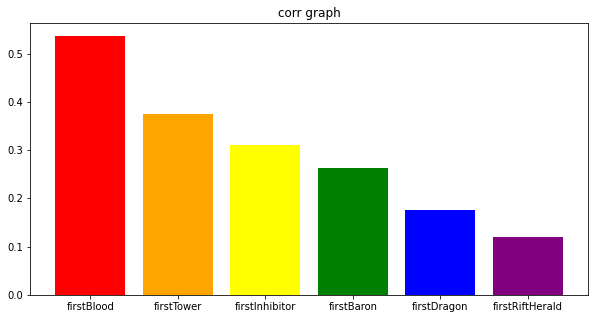

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))

plt.title('corr graph')
plt.bar(first,corr_li,color = ['red', 'orange', 'yellow', 'green','blue','purple']);

In [27]:
data_game[["firstInhibitor","winner"]].groupby(["firstInhibitor"],as_index = False).mean().sort_values(by = "winner",ascending = False)

,firstInhibitor,winner
2,2,1.913448
0,0,1.488528
1,1,1.091307


여기서 보면 억제기를 2팀이 미는 경우 winner의 평균이 거의 2에 가깝고 억제기를 1팀이 미는 경우 winner의 평균이 거의 1에 가까운것을 확인 할 수 있다.

따라서 억제기를 먼저 미는 것과 승리와의 상관관계가 강하다고 할 수 있다.

# 모델링하기

먼저 타겟(winner)를 이용한 기준 모델 만들기
(타겟의 최빈값을 이용함)

기준모델 : 0.51

In [114]:
from sklearn.metrics import accuracy_score


base_major  = data_game['winner'].mode()[0]
y_pred_base = [base_major] * len(data_game['winner'])
accuracy_score1 = accuracy_score(data_game['winner'], y_pred_base)
accuracy_score1

0.5058886829676571

### 학습 데이터, 검증데이터, 테스트 데이터로 나누기

In [112]:
#여러가지 조건 

#1. 게임 지속시간을 빼고 해보자
# 결과) 게임 지속 시간 칼럼을 빼도 딱히 성능에는 영향이 없으니 빼자

df_game = data_game.copy()
df_game.drop(columns = 'gameDuration',inplace = True)

In [115]:
from sklearn.model_selection import train_test_split


train,test = train_test_split(df_game,test_size = 0.2, random_state = 42)

In [116]:
print(train.shape, test.shape)

(40144, 19) (10037, 19)


피쳐와 타겟에 따라서 X_train,y_train,X_test,y_test 만들기

In [117]:
df_game.columns

Index(['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 't1_towerKills', 't1_inhibitorKills',
       't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills', 'spell_use_1', 'spell_use_2'],
      dtype='object')

### 우선 스펠 관련 특성이 굉장히 많은데 이 역시 포함해서 모델을 만들어보고 이후에 빼서 모델을 만들어 보자

X와 y로 나누기

In [118]:
features = df_game.drop(columns = 'winner').columns
target = 'winner'


X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


수치데이터 - 총 타워킬, 총 용 킬 등등

범주형데이터 - 첫번째 용을 먹었나? (1/0) 등등

In [58]:
!pip3 install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 2.4 MB/s 


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from category_encoders import OrdinalEncoder

In [119]:


pipe_dt = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=1, criterion="entropy", max_depth=6),
)
pipe_dt.fit(X_train, y_train)

print("훈련 정확도: ", pipe_dt.score(X_train, y_train))
print("테스트 정확도: ", pipe_dt.score(X_test, y_test))

y_pred = pipe_dt.predict(X_test)

훈련 정확도:  0.9778796333200478
테스트 정확도:  0.976188104015144


너무 정확도가 크다...

데이터 누수가 의심된다

의심요소 - t1_towerKill과 ,t2_inhibitorKills의 칼럼

- 타워는 한 팀당 11개가 있다. 11개를 다 부순다면 거의 게임이 끝났다는 것을 의미함으로 예측이 쉽게 된다

- 억제기도 억제기가 3개가 밀렸다면 거의 게임이 끝났다는 것을 의미하기 때문에(밀리는 팀이 패배) 예측이 쉽다 

In [123]:
a =  df_game.query('t1_towerKills	== 11')

In [127]:
a.shape[0]

5942

In [126]:
a[a.winner == 2].shape[0]

50

1팀이 2팀 타워를 다부순게 약6000건 정도인데 그중에 2팀이 이긴것은 50건 밖에 안된다. 따라서 예측이 쉬워짐으로 해당 칼럼들을 삭제하고 진행한다

### 여기에서 중복치를 제거하고 다시 성능을 확인하자

In [183]:
df_tower_in = df_game.drop(columns = ['t1_inhibitorKills','t2_inhibitorKills','t1_towerKills','t2_towerKills'])

In [187]:
df_tower_in= df_tower_in.drop_duplicates()

In [188]:
train,test = train_test_split(df_tower_in,test_size = 0.2, random_state = 42)

features = df_tower_in.drop(columns = 'winner').columns
target = 'winner'


X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [189]:
pipe_dup = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=1, criterion="entropy", max_depth=6),
)
pipe_dup.fit(X_train, y_train)

print("훈련 정확도: ", pipe_dup.score(X_train, y_train))
print("테스트 정확도: ", pipe_dup.score(X_test, y_test))

훈련 정확도:  0.755100104374229
테스트 정확도:  0.7578747628083492


### 여러가지 모델로 성능을 테스트하자

In [191]:
from xgboost import XGBClassifier


pipe_xg = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="error",  
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        max_depth=7,
        learning_rate=0.1,
    ),
)

In [193]:
pipe_xg.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['spell_use_1', 'spell_use_2'],
                                mapping=[{'col': 'spell_use_1',
                                          'data_type': dtype('O'),
                                          'mapping': 0      1
1      2
NaN   -2
dtype: int64},
                                         {'col': 'spell_use_2',
                                          'data_type': dtype('O'),
                                          'mapping': 0      1
1      2
NaN   -2
dtype: int64}])),
                ('xgbclassifier',
                 XGBClassifier(eval_metric='error', max_depth=7,
                               n_estimators=200, n_jobs=-1, random_state=42))])

In [194]:
print("테스트 정확도", pipe_xg.score(X_test, y_test))


테스트 정확도 0.7537001897533206


### 하이퍼파라미터 튜닝을 통해서 성능을 올리자

In [195]:
from scipy.stats.distributions import uniform

params = {
    "xgbclassifier__max_depth": [2, 4, 6],
    "xgbclassifier__min_child_weight": [2, 4, 8],
    "xgbclassifier__colsample_bytree": uniform(
        loc=0.5, scale=0.5
    ), 
}

In [196]:
# from sklearn.model_selection import RandomizedSearchCV

# randomized_search = RandomizedSearchCV(
#     pipe_xg,
#     param_distributions=params,
#     scoring="roc_auc",
#     n_iter=10,
#     cv=3,
#     verbose=3,
#     random_state=42,
# )
# randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END xgbclassifier__colsample_bytree=0.6872700594236812, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=8;, score=0.837 total time=   0.5s
[CV 2/3] END xgbclassifier__colsample_bytree=0.6872700594236812, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=8;, score=0.837 total time=   0.5s
[CV 3/3] END xgbclassifier__colsample_bytree=0.6872700594236812, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=8;, score=0.838 total time=   0.5s
[CV 1/3] END xgbclassifier__colsample_bytree=0.8659969709057025, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2;, score=0.837 total time=   0.5s
[CV 2/3] END xgbclassifier__colsample_bytree=0.8659969709057025, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2;, score=0.838 total time=   0.5s
[CV 3/3] END xgbclassifier__colsample_bytree=0.8659969709057025, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=2;, score=0.83

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['spell_use_1',
                                                                   'spell_use_2'],
                                                             mapping=[{'col': 'spell_use_1',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': 0      1
1      2
NaN   -2
dtype: int64},
                                                                      {'col': 'spell_use_2',
                                                                       'data_type': dtype('O'),
                                                                       'mapping': 0      1
1      2
NaN   -2
dtype: int64}])),
                                             ('xgbclassifier',
                                              XGBClass

In [197]:
# print("최적 하이퍼파라미터: ", randomized_search.best_params_)
# print("최적 AUC: ", randomized_search.best_score_)

최적 하이퍼파라미터:  {'xgbclassifier__colsample_bytree': 0.8659969709057025, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 2}
최적 AUC:  0.8374229475492787


결과
최적 하이퍼파라미터:  {'xgbclassifier__colsample_bytree': 0.8659969709057025, 'xgbclassifier__max_depth': 2, 'xgbclassifier__min_child_weight': 2}
최적 AUC:  0.8374229475492787

특성 중요도 부분

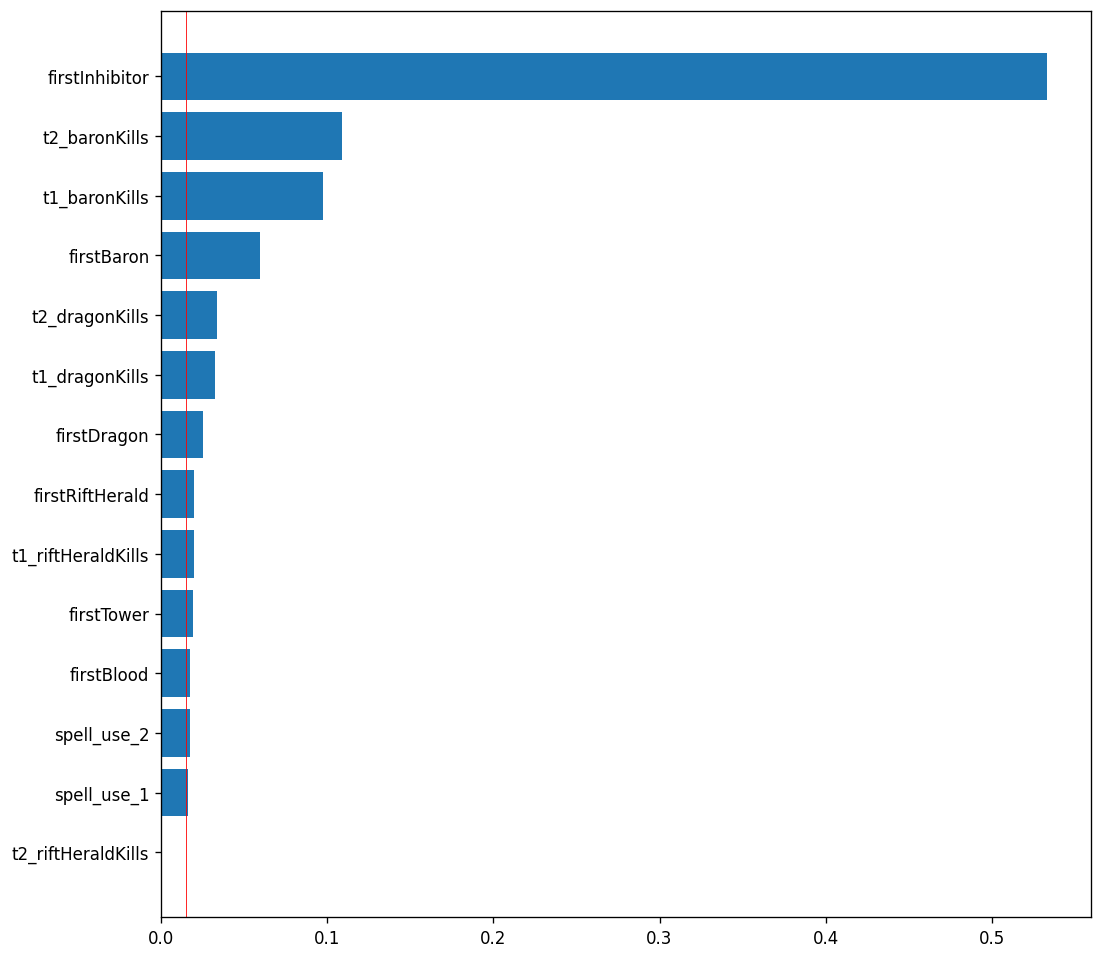

In [198]:
import matplotlib.pyplot as plt

feature_importances = list(
    zip(X_train.columns, pipe_xg.named_steps["xgbclassifier"].feature_importances_)
)
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

plt.figure(figsize=(10, 10), dpi=120)
plt.barh(*list(zip(*feature_importances[::-1])))
plt.axvline(0.015, color="red", linewidth=0.5)

### 알 수 있는점
- 첫번쨰 억제기에 따라서 승패를 예측하기 쉬워진다
- 바론처치에 따라서 영향이 크다
- 바론다음으로는 드래곤 처치가 영향이 크다
- 전령과 용중에서는 용을 우선으로 하자